# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [28]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers.normalization import BatchNormalization # batch normalisation

In [29]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [30]:
import re
from random import shuffle
from glob import glob

train_files = glob('./input/train/*.jpg')
test_files = glob('./input/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

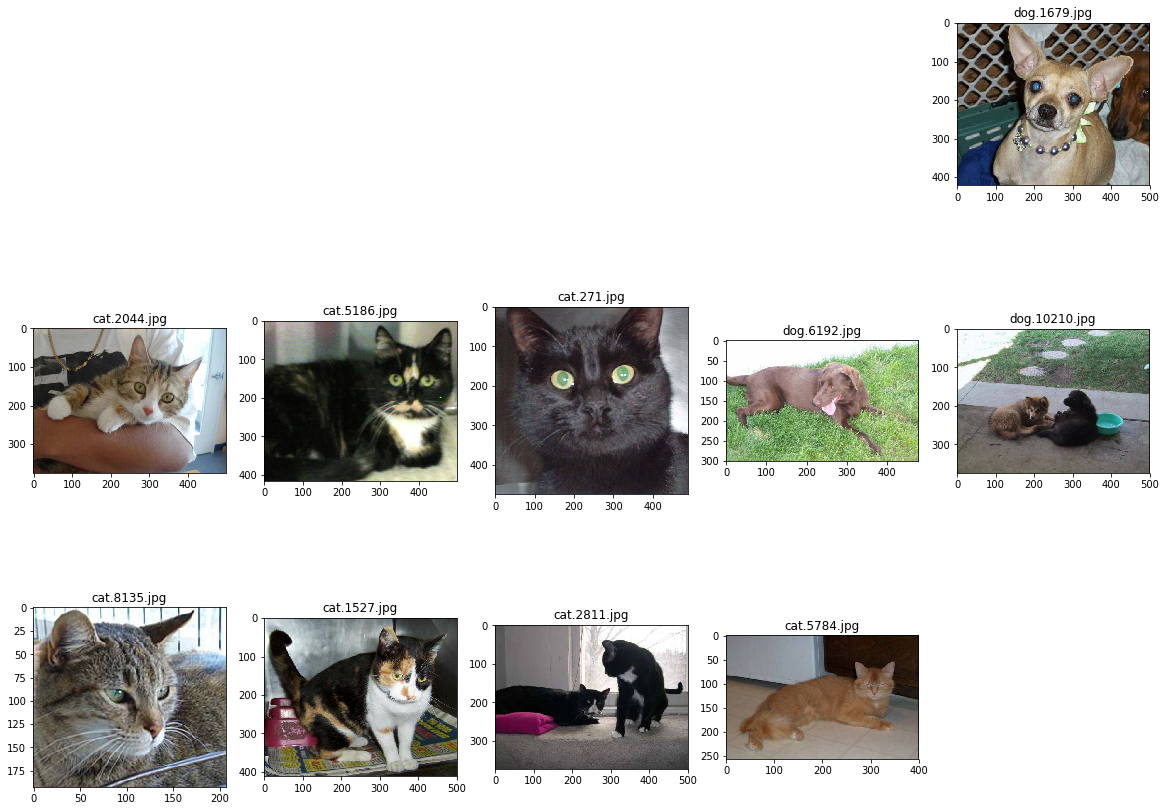

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [32]:
#base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [33]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [34]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Добавляем полносвязный слой

In [35]:
x = base_model.layers[-5].output
x = keras.layers.BatchNormalization()(x) # apply BN to the input (N.B. need to rename
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                activation='relu',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(2e-4))(x)
#x = base_model.layers[-5].output
#x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1,  # один выход
                activation='relu',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(2e-4))(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(2e-4))(x)

model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Компилируем модель и запускаем обучение

In [37]:
import keras.backend as K

def scheduler(epoch):
    if epoch == 0:
        K.set_value(model.optimizer.lr, 1e-3)
    elif epoch == 1:
        K.set_value(model.optimizer.lr, 1e-3)
    elif epoch == 2:
        K.set_value(model.optimizer.lr, 1e-3)
    elif ((epoch > 3) &(epoch < 15)):
        K.set_value(model.optimizer.lr, 5e-4)
    elif ((epoch >= 15) &(epoch < 25)):
        K.set_value(model.optimizer.lr, 5e-4)
    elif ((epoch >= 25) &(epoch < 40)):
        K.set_value(model.optimizer.lr, 1e-4)
    elif ((epoch >= 40) &(epoch < 60)):
        K.set_value(model.optimizer.lr, 1e-4)
    elif (epoch >= 90):
        K.set_value(model.optimizer.lr, 2e-5)
    else:
        K.set_value(model.optimizer.lr, 1e-4)
    print("epoch=",epoch)
    return K.get_value(model.optimizer.lr)

change_lr = keras.callbacks.LearningRateScheduler(scheduler)

model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [38]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 200  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))



In [60]:
# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=20,  # число вызовов генератора за эпоху
        epochs=100,  # число эпох обучения
        validation_data=validation_data,
        callbacks=[change_lr])

epoch= 0
Epoch 1/100
20/20 [==============================] - 31s 2s/step - loss: 0.2863 - acc: 0.9500 - val_loss: 0.6728 - val_acc: 0.7150
epoch= 1
Epoch 2/100
20/20 [==============================] - 29s 1s/step - loss: 0.3726 - acc: 0.9281 - val_loss: 0.8771 - val_acc: 0.6700
epoch= 2
Epoch 3/100
20/20 [==============================] - 29s 1s/step - loss: 0.3937 - acc: 0.9219 - val_loss: 0.7495 - val_acc: 0.7000
epoch= 3
Epoch 4/100
20/20 [==============================] - 29s 1s/step - loss: 0.3932 - acc: 0.9094 - val_loss: 0.5513 - val_acc: 0.7700
epoch= 4
Epoch 5/100
20/20 [==============================] - 29s 1s/step - loss: 0.3594 - acc: 0.9297 - val_loss: 0.4513 - val_acc: 0.8250
epoch= 5
Epoch 6/100
20/20 [==============================] - 29s 1s/step - loss: 0.3433 - acc: 0.9531 - val_loss: 0.3588 - val_acc: 0.8950
epoch= 6
Epoch 7/100
20/20 [==============================] - 29s 1s/step - loss: 0.3353 - acc: 0.9609 - val_loss: 0.3266 - val_acc: 0.9150
epoch= 7
Epoch 8/100

epoch= 36
Epoch 37/100
20/20 [==============================] - 30s 1s/step - loss: 0.2606 - acc: 0.9672 - val_loss: 0.2790 - val_acc: 0.9650
epoch= 37
Epoch 38/100
20/20 [==============================] - 30s 1s/step - loss: 0.2549 - acc: 0.9750 - val_loss: 0.2767 - val_acc: 0.9650
epoch= 38
Epoch 39/100
20/20 [==============================] - 29s 1s/step - loss: 0.2716 - acc: 0.9594 - val_loss: 0.2742 - val_acc: 0.9650
epoch= 39
Epoch 40/100
20/20 [==============================] - 30s 2s/step - loss: 0.2308 - acc: 0.9812 - val_loss: 0.2783 - val_acc: 0.9650
epoch= 40
Epoch 41/100
20/20 [==============================] - 29s 1s/step - loss: 0.2146 - acc: 0.9906 - val_loss: 0.2755 - val_acc: 0.9650
epoch= 41
Epoch 42/100
20/20 [==============================] - 29s 1s/step - loss: 0.2254 - acc: 0.9875 - val_loss: 0.2800 - val_acc: 0.9550
epoch= 42
Epoch 43/100
20/20 [==============================] - 29s 1s/step - loss: 0.2145 - acc: 0.9875 - val_loss: 0.2855 - val_acc: 0.9500
epoch=

epoch= 72
Epoch 73/100
20/20 [==============================] - 30s 1s/step - loss: 0.1832 - acc: 0.9891 - val_loss: 0.2571 - val_acc: 0.9550
epoch= 73
Epoch 74/100
20/20 [==============================] - 29s 1s/step - loss: 0.1915 - acc: 0.9844 - val_loss: 0.2489 - val_acc: 0.9650
epoch= 74
Epoch 75/100
20/20 [==============================] - 30s 1s/step - loss: 0.2158 - acc: 0.9703 - val_loss: 0.2399 - val_acc: 0.9650
epoch= 75
Epoch 76/100
20/20 [==============================] - 30s 1s/step - loss: 0.1931 - acc: 0.9891 - val_loss: 0.2355 - val_acc: 0.9600
epoch= 76
Epoch 77/100
20/20 [==============================] - 29s 1s/step - loss: 0.2064 - acc: 0.9781 - val_loss: 0.2344 - val_acc: 0.9550
epoch= 77
Epoch 78/100
20/20 [==============================] - 29s 1s/step - loss: 0.1843 - acc: 0.9891 - val_loss: 0.2334 - val_acc: 0.9550
epoch= 78
Epoch 79/100
20/20 [==============================] - 29s 1s/step - loss: 0.1818 - acc: 0.9875 - val_loss: 0.2392 - val_acc: 0.9500
epoch=

In [61]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=1e-7)

In [76]:
# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=20,  # число вызовов генератора за эпоху
        epochs=25,  # число эпох обучения
        validation_data=validation_data,
        callbacks=[reduce_lr])

Epoch 1/25
20/20 [==============================] - 31s 2s/step - loss: 0.1625 - acc: 0.9953 - val_loss: 0.2206 - val_acc: 0.9600
Epoch 2/25
20/20 [==============================] - 32s 2s/step - loss: 0.1613 - acc: 0.9937 - val_loss: 0.2210 - val_acc: 0.9600
Epoch 3/25
20/20 [==============================] - 29s 1s/step - loss: 0.1614 - acc: 0.9922 - val_loss: 0.2212 - val_acc: 0.9600
Epoch 4/25
20/20 [==============================] - 30s 1s/step - loss: 0.1676 - acc: 0.9859 - val_loss: 0.2212 - val_acc: 0.9600
Epoch 5/25
20/20 [==============================] - 29s 1s/step - loss: 0.1566 - acc: 0.9937 - val_loss: 0.2204 - val_acc: 0.9600
Epoch 6/25
20/20 [==============================] - 29s 1s/step - loss: 0.1636 - acc: 0.9906 - val_loss: 0.2203 - val_acc: 0.9600
Epoch 7/25
20/20 [==============================] - 29s 1s/step - loss: 0.1546 - acc: 0.9953 - val_loss: 0.2204 - val_acc: 0.9600
Epoch 8/25
20/20 [==============================] - 29s 1s/step - loss: 0.1686 - acc: 0.98

In [77]:
reduce_lr2 = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=2, min_lr=1e-7)

In [78]:
# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=20,  # число вызовов генератора за эпоху
        epochs=10,  # число эпох обучения
        validation_data=validation_data,
        callbacks=[reduce_lr2])

Epoch 1/10
20/20 [==============================] - 30s 1s/step - loss: 0.1529 - acc: 0.9937 - val_loss: 0.2208 - val_acc: 0.9600
Epoch 2/10
20/20 [==============================] - 30s 1s/step - loss: 0.1490 - acc: 0.9953 - val_loss: 0.2203 - val_acc: 0.9600
Epoch 3/10
20/20 [==============================] - 29s 1s/step - loss: 0.1585 - acc: 0.9969 - val_loss: 0.2205 - val_acc: 0.9600
Epoch 4/10
20/20 [==============================] - 29s 1s/step - loss: 0.1793 - acc: 0.9875 - val_loss: 0.2198 - val_acc: 0.9600
Epoch 5/10
20/20 [==============================] - 30s 1s/step - loss: 0.1489 - acc: 1.0000 - val_loss: 0.2197 - val_acc: 0.9650
Epoch 6/10
20/20 [==============================] - 29s 1s/step - loss: 0.1512 - acc: 0.9937 - val_loss: 0.2202 - val_acc: 0.9650
Epoch 7/10
20/20 [==============================] - 29s 1s/step - loss: 0.1548 - acc: 0.9969 - val_loss: 0.2199 - val_acc: 0.9650
Epoch 8/10
20/20 [==============================] - 29s 1s/step - loss: 0.1543 - acc: 0.99

In [79]:
#K.set_value(model.optimizer.lr, 1e-8)

def scheduler(epoch):
    if epoch == 0:
        K.set_value(model.optimizer.lr, 5e-5)
    elif epoch == 1:
        K.set_value(model.optimizer.lr, 1e-5)
    elif epoch == 2:
        K.set_value(model.optimizer.lr, 1e-6)
    else:
        K.set_value(model.optimizer.lr, 1e-6)
    print("epoch=",epoch)
    return K.get_value(model.optimizer.lr)

change_lr2 = keras.callbacks.LearningRateScheduler(scheduler)


In [80]:
# запускаем процесс обучения
#model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
#        steps_per_epoch=20,  # число вызовов генератора за эпоху
#        epochs=3,  # число эпох обучения
#        validation_data=validation_data,
#        callbacks=[change_lr2])

In [81]:
#model.save('cats-dogs-vgg16.hdf5')

In [82]:
#model = keras.models.load_model('cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [83]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

In [84]:
#%matplotlib inline
#from matplotlib import pyplot as plt
#fig = plt.figure(figsize=(20, 20))
#for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
#    subplot = fig.add_subplot(i // 5 + 1, 5, i)
#    plt.imshow(plt.imread(path));
#    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [85]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [86]:
# LogLoss = 0.13404